## Polygons

We will use them to:

    1. check for intersections
    2. check if a point is inside a polygon
    3. draw polygons from visibility to get vis regions and store them
    


In [127]:
from skgeom import Point2,Segment2,arrangement,intersection
from shapely.geometry import Polygon,Point, MultiPoint
from pprint import pprint
import geopandas

In [137]:
def skgeomPolyFromNode(node:list):
    '''
        Helper function to build a skgeom polygon from a list of segments
        @args:
            node:[segments] --> Required node
        @returns --> (skgeom)Polygon
    '''
    pointSet = []
    for seg in node:
        if(seg.source() not in pointSet):
            pointSet.append(seg.source())
        if(seg.target() not in pointSet):
            pointSet.append(seg.target())

    poly = skgeom.Polygon(pointSet)
    return poly

In [139]:
def shapelyPolyFromNode(node:list):
    '''
        Helper function to build a shapely polygon from a list of segments
        @args:
            node:[segments] --> Required node
        @returns --> (shapely)Polygon
    '''
    pointSet = []
    for seg in node:
        if(seg.source() not in pointSet):
            pointSet.append((seg.source().x(),seg.source().y()))
        if(seg.target() not in pointSet):
            pointSet.append((seg.target().x(),seg.target().y()))
    
    poly = Polygon(pointSet)
    return poly


In [140]:
def intersectHelper(segment, node:list):
    '''
        Intersection helper to find the same between a halfedge and a node (list of segments).
        @returns-> List of segments

        TODO: Remove duplicates in ret.
    '''
    ret = []
    part1 = Segment2(segment.source().point(), segment.target().point())

    for segs in node:
        isx = intersection(part1, segs)
        if type(isx) == Segment2:
            ret.append(isx)

    return ret


In [141]:
def updateVisibility(queryPoint:Point2, node:list, arrangement:arrangement):
    '''
        Plain visible region calculation
        @args:
            query point:Point2  --> query point
            node:[segments] --> Target node
            arrangement:Arrangement --> The arrangement (see docs)
        @returns:
            visible region:[segments]
    '''
    vs = RotationalSweepVisibility(arrangement)
    face = arrangement.find(queryPoint)
    vx = vs.compute_visibility(queryPoint, face)
    vis = []

    # Draw visibility --optional, should be removed in prod
    for he in arr.halfedges:
        draw.draw(he.curve(), visible_point=False)
    draw.draw(queryPoint, color='magenta')

    for v in vx.halfedges:
        vis+=intersectHelper(v,node)

    ret = []
    [ret.append(x) for x in vis if x not in ret]
    for v in ret:
        draw.draw(v, color='red', visible_point=False)

    return ret

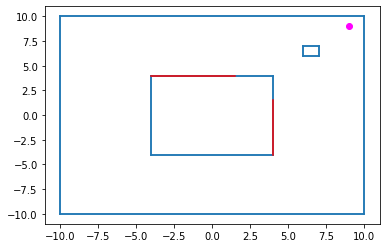

In [142]:
M = 10
outer = [
    Segment2(Point2(-M, -M), Point2(-M, M)), Segment2(Point2(-M, M), Point2(M, M)),
    Segment2(Point2(M, M), Point2(M, -M)), Segment2(Point2(M, -M), Point2(-M, -M))
]
arr = arrangement.Arrangement()

for bounds in outer:
    arr.insert(bounds)

qp = Point2(9,9)

T=4
Target = [
    Segment2(Point2(-T, -T), Point2(-T, T)), Segment2(Point2(-T, T), Point2(T, T)),
    Segment2(Point2(T, T), Point2(T, -T)), Segment2(Point2(T, -T), Point2(-T, -T))
]

Obstacle = [
    Segment2(Point2(6, 7), Point2(7, 7)), Segment2(Point2(7, 7), Point2(7, 6)),
    Segment2(Point2(7, 6), Point2(6, 6)), Segment2(Point2(6, 6), Point2(6, 7))
]

for sides in Target:
    arr.insert(sides)

for sides in Obstacle:
    arr.insert(sides)

vis = updateVisibility(qp,Target,arr)

In [143]:
vrSet = []
for seg in vis:
    VRvertices = [(qp.x(),qp.y())]
    if(seg.source() not in VRvertices):
        VRvertices.append((seg.source().x(),seg.source().y()))
    if(seg.target() not in VRvertices):
        VRvertices.append((seg.target().x(),seg.target().y()))
    vrSet.append(Polygon(VRvertices))



In [144]:
for vr in vrSet:
    print(list(vr.exterior.coords))

[(9.0, 9.0), (-4.0, 4.0), (1.5, 4.0), (9.0, 9.0)]
[(9.0, 9.0), (4.0, -4.0), (4.0, 1.5), (9.0, 9.0)]


In [145]:

# def insideVisibleRegion(visibleRegionSet, node):
#     nodePolygon = polyFromNode(node)
#     for vr in visibleRegionSet:
#         print(vr)
#         print(nodePolygon)
#         intersection = boolean_set.intersect(nodePolygon, nodePolygon)
#         if(type(intersection) == Polygon):
#             return True
    
#     return False

'\n    Visible Region intersection\n'

In [163]:
'''
    Test if VR and (skgeom)polygon intersect
        @args:
            visibilityRegionSet:[Polygons] --> VR from query point
            node:[segments] --> obstacle
        @returns:
            bool --> True when polygon and VR intersect, False o.w.
'''
def insideVisibleRegion(visibleRegionSet:list, node:list):
    nodePolygon = shapelyPolyFromNode(node)
    for vrPolygon in visibleRegionSet:
        intersection = nodePolygon.boundary.intersection(vrPolygon.boundary)
        print(intersection)
        if isinstance(intersection,MultiPoint):
            return True
    
    return False

In [164]:
check = insideVisibleRegion(vrSet,Obstacle)
print(check)

POINT (6 7)
POINT (7 6)


In [166]:
# Testing
Ob2 = [
    Segment2(Point2(-6, -7), Point2(-7, -7)), Segment2(Point2(-7, -7), Point2(-7, -6)),
    Segment2(Point2(-7, -6), Point2(-6, -6)), Segment2(Point2(-6, -6), Point2(-6, -7))
]
check = insideVisibleRegion(vrSet,Ob2)
print(check)

LINESTRING EMPTY
LINESTRING EMPTY
False
